## Simple Model -- Undercomplete AE

In [1]:
# Code here
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.init as weight_init
import matplotlib.pyplot as plt
import pdb
import numpy as np


#parameters
batch_size = 128

preprocess = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])

#Loading the train set file
dataset = datasets.MNIST(root='./data',
                            transform=preprocess,  
                            download=True)

loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [9]:
hidden_sizes=[4, 8,12]
input_size = 28*28
#hidden_size = 256
# out_sizes=[16,32,64,128]
num_classes = 2
num_epochs = 50
learning_rate = 0.01
momentum_rate = 0.9

### Autoencoder Class

In [10]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, int(hidden_size/2)),
            nn.ReLU(),
            nn.Linear(int(hidden_size/2), num_classes),
        )
        self.decoder = nn.Sequential(
            nn.Linear(num_classes, int(hidden_size/2)),
            nn.ReLU(),
            nn.Linear(int(hidden_size/2), hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Tanh()
        )
    
    def forward(self,x):
        h = self.encoder(x)
        xr = self.decoder(h)
        return xr,h

#Misc functions
def loss_plot(losses):
    max_epochs = len(losses)
    times = list(range(1, max_epochs+1))
    plt.figure(figsize=(30, 7))
    plt.xlabel("epochs")
    plt.ylabel("cross-entropy loss")
    return plt.plot(times, losses)

In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Using CUDA ', use_cuda)

hidden_size =256
net = AE()
net = net.to(device)

#Mean square loss function
criterion = nn.MSELoss()

#Parameters
learning_rate = 1e-2
weight_decay = 1e-5

#Optimizer and Scheduler
#SGD
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
# optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
##RMSProp
# torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
##Adam
# torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
##Adagrad
# torch.optim.Adagrad(params, lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, threshold=0.001, patience=5, verbose = True)

Using CUDA  False


In [12]:


#Training
TotalLoss = {}
for index , hs in enumerate(hidden_sizes):
    total_loss, cntr = 0, 0
    epochLoss = []
    for epoch in range(num_epochs):
        for i,(images,_) in enumerate(loader):

            images = images.view(-1, 28*28)
            images = images.to(device)

            # Initialize gradients to 0
            optimizer.zero_grad()

            # Forward pass (this calls the "forward" function within Net)
            hidden_size = hs
            outputs, _ = net(images)

            # Find the loss
            loss = criterion(outputs, images)

            # Find the gradients of all weights using the loss
            loss.backward()

            # Update the weights using the optimizer and scheduler
            optimizer.step()

            total_loss += loss.item()
            cntr += 1

        scheduler.step(total_loss/cntr)
        print ('Epoch [%d/%d], Loss: %.4f' 
                       %(epoch+1, num_epochs, total_loss/cntr))
        epochLoss.append(total_loss/cntr)
    TotalLoss[hs] = epochLoss
    

Epoch [1/50], Loss: 0.7906
Epoch [2/50], Loss: 0.7373
Epoch [3/50], Loss: 0.7094
Epoch [4/50], Loss: 0.6924
Epoch [5/50], Loss: 0.6799
Epoch [6/50], Loss: 0.6701
Epoch [7/50], Loss: 0.6623
Epoch [8/50], Loss: 0.6561
Epoch [9/50], Loss: 0.6509
Epoch [10/50], Loss: 0.6466
Epoch [11/50], Loss: 0.6429
Epoch [12/50], Loss: 0.6397
Epoch [13/50], Loss: 0.6369
Epoch [14/50], Loss: 0.6344
Epoch [15/50], Loss: 0.6322
Epoch [16/50], Loss: 0.6302
Epoch [17/50], Loss: 0.6283
Epoch [18/50], Loss: 0.6267
Epoch [19/50], Loss: 0.6251
Epoch [20/50], Loss: 0.6237
Epoch [21/50], Loss: 0.6224
Epoch [22/50], Loss: 0.6212
Epoch [23/50], Loss: 0.6200
Epoch [24/50], Loss: 0.6189
Epoch [25/50], Loss: 0.6179
Epoch [26/50], Loss: 0.6169
Epoch [27/50], Loss: 0.6160
Epoch [28/50], Loss: 0.6151
Epoch [29/50], Loss: 0.6143
Epoch [30/50], Loss: 0.6135
Epoch [31/50], Loss: 0.6127
Epoch [32/50], Loss: 0.6119
Epoch [33/50], Loss: 0.6112
Epoch [34/50], Loss: 0.6105
Epoch [35/50], Loss: 0.6099
Epoch [36/50], Loss: 0.6092
E

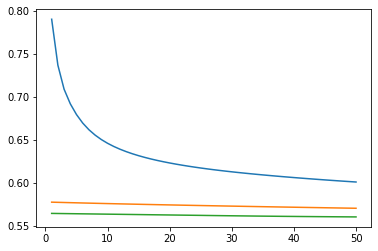

In [14]:
# print(TotalLoss)
#a= loss_plot(epochLoss)
num_epochs = list(range(1,51))
for _hs in hidden_sizes:
#     print(num_epochs, _hs, hidden_sizes)
    plt.plot(num_epochs, TotalLoss[_hs])